In [2]:
%cd ~/Dropbox/research/football/code/sfm/
import trainsfm
import sfmnet
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio 

/Users/ajaffe/Dropbox/research/football/code/sfm


[]

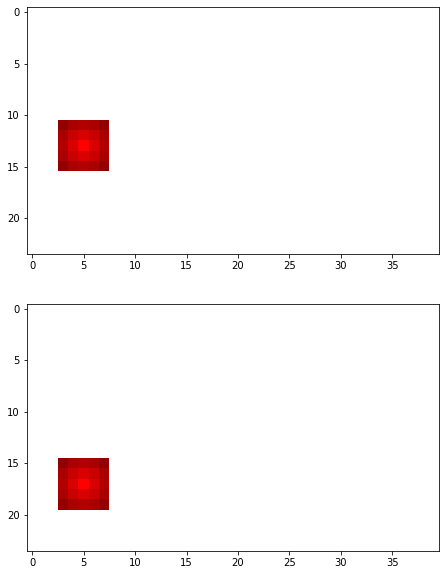

In [3]:
H=24
W=40
im_1 = torch.tensor(imageio.imread('~/Dropbox/research/football/datasets/gradient_ball_slow_speed_40x24/image0.png'), dtype=torch.float32).permute(2, 0, 1) / 255 
im_2 = torch.tensor(imageio.imread('~/Dropbox/research/football/datasets/gradient_ball_slow_speed_40x24/image1.png'), dtype=torch.float32).permute(2, 0, 1) / 255
fig, ax = plt.subplots(2, figsize=(20,10))
ax[0].imshow(im_1.permute(1,2,0))
ax[1].imshow(im_2.permute(1,2,0))
plt.plot()

In [4]:
def vis(input, output, mask, flow, spacing = 5):
    H = input.shape[1]
    W = input.shape[2]
    fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(W/3,H/3))
    first = input[0:3].permute(1,2,0)
    second = input[3:6].permute(1,2,0)
    output = output.permute(1,2,0)
    ax[0][0].imshow(first)
    ax[0][0].set_title('First image')
    
    ax[1][0].imshow(second)
    ax[1][0].set_title('Second image')

    ax[0][1].imshow(output)
    ax[0][1].set_title('Predicted Second Image')

    # This one will throw if the v.f. is identically 0
    ax[1][1].imshow(mask, cmap='Greens')
    xflow = flow[:,:,0]
    yflow = flow[:,:,1]
    i, j = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    mask = np.logical_or((i % spacing != 0), (j % spacing != 0))
    mx = np.ma.masked_array(xflow, mask=mask)
    my = np.ma.masked_array(yflow, mask=mask)
    ax[1][1].quiver(mx * W/2, my * H/2, scale=1, scale_units='xy', angles='xy', color='red', width=0.0001 * W) 
    ax[1][1].set_title('Mask and Flow')
    fig.show()
    




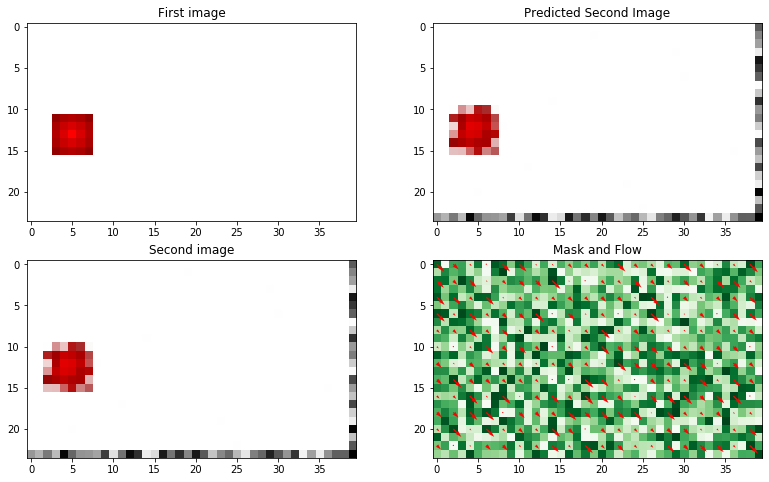

In [5]:
def transform(input, mask, displacement):
    flow = displacement.unsqueeze(-2).unsqueeze(-2) * mask.unsqueeze(-1)
    identity_affine_transform = torch.tensor([[1,0,0],[0,1,0]], dtype=torch.float32)
    identity = F.affine_grid( \
        identity_affine_transform.unsqueeze(0), \
        (1, 3, H, W), \
        align_corners=False
    )

    grid = identity + flow.unsqueeze(0)
    return F.grid_sample(input.unsqueeze(0), grid, align_corners=False).squeeze(0), flow


input = im_1
displacement = torch.tensor([2/W,2/H], dtype=torch.float32)
mask = torch.tensor(np.random.uniform(low=0.,high=1.0,size=(H,W)),dtype=torch.float32)
out, flow = transform(input, mask, displacement)
vis(torch.cat((input, out)), out, mask, flow, spacing=2)

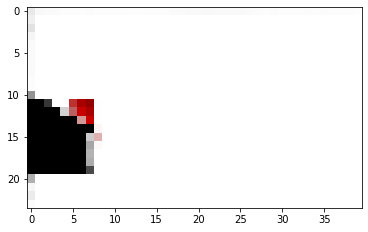

In [16]:
chkpt = torch.load('/Users/ajaffe/Dropbox/research/models/569252.pt', map_location=torch.device('cpu'))
m = sfmnet.SfMNet(H=24, W=40, conv_depth=3, fc_layer_width=256)
with torch.no_grad():
    m.load_state_dict(chkpt['model_state_dict'])
    input = torch.cat((im_1, im_2))
    out, mask, flow, displacement = m(input.unsqueeze(0))
    out = out.squeeze()
    mask = mask.squeeze()
    flow = flow.squeeze()
    displacement = displacement.squeeze()
    out2, flow2 = transform(im_1, mask, displacement)
    plt.imshow(out.permute(1,2,0))
    plt.imshow(out2.permute(1,2,0))

In [20]:
print(m)

SfMNet(
  (conv_encode): ModuleList(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bns_encode): ModuleList(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff